In [1]:
%pylab inline
import scipy.stats

from sigvisa.infer.correlations.event_proposal import correlation_location_proposal, generate_historical_db
#import seaborn as sns
from sigvisa.infer.coarse_to_fine_init import ModelSpec, EventRunSpec, do_coarse_to_fine, initialize_from, do_inference


Populating the interactive namespace from numpy and matplotlib


In [2]:
#from sigvisa.experiments.aftershock_region import evids, stas
import cPickle as pickle
from sigvisa.source.event import get_event

stas = ['ASAR', 'MKAR', 'CMAR', 'FITZ']

doublet = 5334939

#evids = [5334501, 5334726, 5335822, 5349536, 
#         5336237, 5335424, 5349441, 
#         5336889, 5336015]
evids = [doublet,]

rs = EventRunSpec(evids=evids, stas=stas, runids=(1,), disable_conflict_checking=True)
ms = ModelSpec(template_model_type="param", wiggle_family="iid", 
               max_hz=10.0, inference_preset="openworld", raw_signals=True)
sg = rs.build_sg(ms)

doublet_ev = get_event(evid=doublet)
sg.event_start_time = doublet_ev.time-150
sg.event_end_time = doublet_ev.time + 150

with open("corr.sg", 'wb') as f:
    pickle.dump(sg, f)
    
#with open("corr.sg", 'rb') as f:
#    sg = pickle.load(f)

1240241574.35 1240242005.69
1240241946.92 1240242164.7
1240241739.3 1240241949.3
1240241505.56 1240241715.56
1240249325.45 1240249535.45
1240249697.42 1240249907.42
no arrivals found for evid 5349536 at station CM16
no arrivals found for evid 5349536 at station FITZ


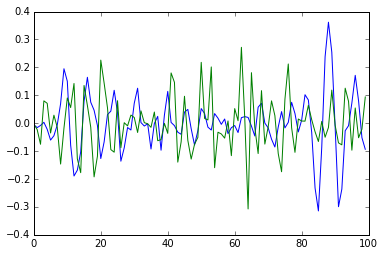

In [3]:
stas = ['AS12', 'MK31', 'CM16', 'FITZ']

#nearby_evids = [5334501, 5334726, 5335822, 5349536, 5336237, 5335424, 5349441]
#irrelevant_evids = [5321052, 5301042, 5301165, 5301302, 5301783, 5311139 ]
#hevids = nearby_evids + irrelevant_evids
hevids = [5335822, 5349536]
history = generate_historical_db(stas, hevids, bands=["freq_0.8_4.5"], chans=["auto"],len_s=10.0)
c1 = history[0][1][("MK31", "BHZ", "freq_0.8_4.5")]
c2 = history[1][1][("MK31", "BHZ", "freq_0.8_4.5")]

plot(c1)
plot(c2)


In [4]:
from sigvisa.signals.io import load_event_station_chan
sta="MK31"
chan="BHZ"
band="freq_0.8_4.5"
srate=10.0
evid1 = 5334939
evid2 = 5335822
evid3 = 5349536

w1 =  load_event_station_chan(evid1, sta, chan, evtype="leb")
w1 = w1.filter("%s;hz_%f" % (band, srate))
print len(w1.data)

w2 =  load_event_station_chan(evid2, sta, chan, evtype="leb")
w2 = w2.filter("%s;hz_%f" % (band, srate))

w3 =  load_event_station_chan(evid3, sta, chan, evtype="leb")
w3 = w3.filter("%s;hz_%f" % (band, srate))

1240246021.58 1240246231.58
2500
1240241946.92 1240242164.7
1240249697.42 1240249907.42


In [5]:
from sigvisa.models.noise.armodel.model import ARModel, ErrorModel
from sigvisa.models.noise.armodel.learner import ARLearner

sdata = w1.data
sdata.data[sdata.mask] = np.nan
ssdata = sdata.copy()


l = ARLearner(sdata[200:2000], sf=10)
p, std = l.yulewalker(10)
em = ErrorModel(0, std)
nm = ARModel(p, em, float(l.c))
llarray = np.zeros(sdata.shape)
arll = nm.fastAR_missingData(sdata.data, nm.c, nm.em.std, llarray=llarray, mask=sdata.mask)

print arll

-1350.31668068


In [6]:
from sigvisa.database.dataset import DET_TIME_COL
atime =  w3['event_arrivals'][0,DET_TIME_COL]
print atime
aidx = int((atime - w3['stime'])*w3['srate'])
print aidx

1240249707.42
300


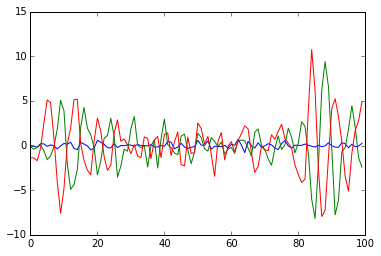

In [7]:
atime= w3["event_arrivals"][0][2]

c2 = w3.data[300:400]
plot(c2)

c1 = w2.data[300:400]
plot(c1)

c0 = w1.data[300:400]
plot(c0)

In [8]:
from sigvisa.ssms_c import TransientCombinedSSM, ARSSM
from sigvisa.models.noise.noise_util import get_noise_model
import pyublas

nmn, nmid, _ = get_noise_model(waveform=w1, model_type="ar", order=10, return_details=True)
signal_arssm = ARSSM(np.array(nm.params, dtype=np.float), nm.em.std**2, 0.0, nm.c)
noise_arssm = ARSSM(np.array(nmn.params, dtype=np.float), nmn.em.std**2, 0.0, nmn.c)

nm_source, nmid, _ = get_noise_model(waveform=w3, model_type="ar", order=10, return_details=True)
source_arssm = ARSSM(np.array(nm_source.params, dtype=np.float), nm_source.em.std**2, 0.0, nm_source.c)

#sigma2_B = 1.27656228965 # nm.em.std**2
#noise_arssm = ARSSM(np.array((0.0), dtype=np.float), sigma2_B, 0.0, nm.c)
iid_arssm = ARSSM(np.array((0,), dtype=np.float), 1.0, 0.0, 0.0)



tau = 1.0
c = tau*c2
kappa = 1-tau**2*k2
beta = 0.8

def arlik_t_beta(sdata, c, kappa, t, noise_arssm, iid_arssm, beta):
    npts = len(sdata)
    n = len(c)
    cbeta = (c*beta).copy()
    components = [ (noise_arssm, 0, npts, None), ]
    #components.append((source_arssm, t, n, -np.ones(n)*beta))
    #components = [ (signal_arssm, 0, t, None), (noise_arssm, t, n, None), (signal_arssm, t+n, npts-t-n, None)]
    #components.append((iid_arssm, t, n, np.ones(n)*np.sqrt(kappa)*beta))
    components.append((None, t, n, cbeta))
    tssm = TransientCombinedSSM(components, 1e-6)
    
    ll = tssm.run_filter(sdata)
    
    return ll

#print nm.log_p(ssdata)
ts = np.arange(0, 2000)


NameError: name 'k2' is not defined

-20741.527311
379


/home/dmoore/.virtualenvs/sigvisa/local/lib/python2.7/site-packages/numpy/ma/core.py:3683: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  check = ndarray.__eq__(self.filled(0), other)


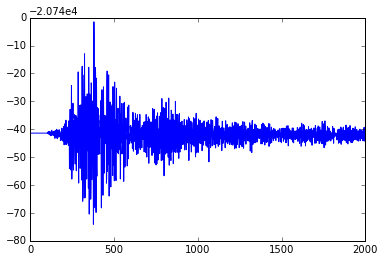

In [9]:
beta = 0.1
lls = [arlik_t_beta(ssdata, c, kappa, t, noise_arssm, iid_arssm, beta) for t in ts]
plot(ts, lls)
print np.max(lls)
print np.argmax(lls)

3.32665330661 3.3126252505


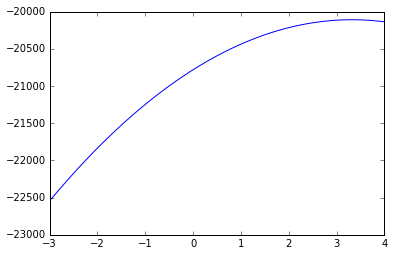

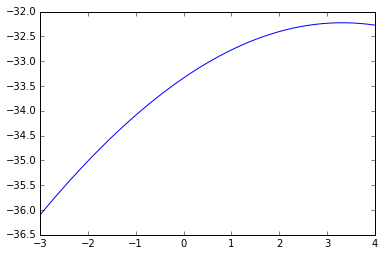

In [10]:
idx = 379 #296
c0 = w1.data[idx:idx+100]

def score_beta(beta):
    ll = arlik_t_beta(ssdata, c, kappa, idx, noise_arssm, iid_arssm, beta) 
    #llmax = np.max(lls2)
    #score = np.log(np.sum(np.exp(lls2-llmax)))+llmax
    return ll

def score2_beta(beta):
    return -np.linalg.norm(c0-beta*c)

betas = np.linspace(-3, 4.0, 500)
scores = [score_beta(beta) for beta in betas]
scores2 = [score2_beta(beta) for beta in betas]

plot(betas, scores)
figure()
plot(betas, scores2)
print betas[np.argmax(scores)], betas[np.argmax(scores2)]

In [52]:
# assume we have pre-summed llarrays, of the form cache[i] = sum(llarray[:i]) + sum(llarray[i+p:])
# that is, we know exactly what we'll predict up until time i, and we know after time i+p, but 
# during the period itself and for the p steps after our predictions will differ

import scipy.weave as weave
from scipy.weave import converters

iidcode = """
for (int k=0; k < N-n; ++k) {
    double Bc=0;
    for(int i=k; i < k+n; ++i) {
       if (mask(i)) continue;
       Bc += S(i)*c(i-k);
    }
    result(k) = Bc > 0 ? Bc*Bc : 0;
}
"""
S = w1.data.data
S -= np.mean(w1.data)
mask = w1.data.mask
c = np.array(c1/np.linalg.norm(c1))
N = len(S)
n = len(c)
result = np.empty((N-n),)
weave.inline(iidcode,['S', 'mask', 'c', 'N', 'n', 'result',],type_converters = converters.blitz,
                 verbose=2,compiler='gcc',)



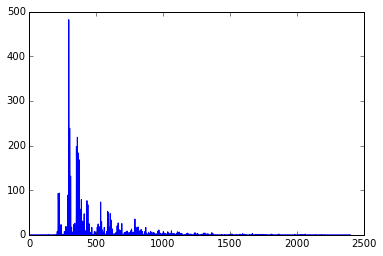

In [53]:
plot(result)

In [122]:
from sigvisa.models.noise.armodel.model import fastar_support
import scipy.weave as weave
from scipy.weave import converters


arcode = """
for (int k=0; k < N-n-n_p; ++k) {
//for (int k=100; k < 500; ++k) {
    double norm2B=0;
    double Bc=0;
    for(int i=k; i < k+n; ++i) {
       if (mask(i)) continue;
       Bc += S(i)*c(i-k);
       norm2B += S(i)*S(i);
    }
    double beta = 10; //Bc > 0 ? Bc : 0;
    
    for (int i=k; i < k+n; ++i) {
        tmpS(i) = S(i) - beta*c(i-k);
    }
    for (int i=k-n_p; i < k; ++i) {
       if (i < 0) continue;
       tmpS(i) = S(i);
    }
    
    for (int kk=0; kk < n_p; ++kk) {
        for (int kj=0; kj < n_p; ++kj) {
        K(kk, kj) = 0;
        tmp(kk, kj) = 0;
        }
        K(kk, kk) = 1e4;
        u(kk) = 0;
    }
        double r2 = compute_ar(n_p, mask, tmpS, var, p, tmp, k, k+n+n_p, K, u, llarray, 0);

    
    for (int kk=0; kk < n_p; ++kk) {
        for (int kj=0; kj < n_p; ++kj) {
        K(kk, kj) = 0;
        tmp(kk, kj)=0;
        }
        K(kk, kk) = 1e4;
        u(kk) = 0;
    }
        double r1 = compute_ar(n_p, mask, S, var, p, tmp, k, k+n+n_p, K, u, llarray, 0);

    if(k==296 || k == 390) {
      printf("%d, %f - %f= %f, %f \\n", k, r2, r1, r2-r1, beta);
    }
    result(k) = r2-r1;
}

"""

S = (w1.data.data - np.mean(w1.data)).copy()

tmpS = S.copy()
mask = w1.data.mask
c = np.array(c1/np.linalg.norm(c1))
N = len(S)
n = len(c)

#nm = nmn
p = np.array(nm.params).copy()
n_p = len(p)
tmp = np.zeros((n_p, n_p))
K = np.eye(n_p) * 1.0e4
u = np.zeros((n_p,))
var = float(nm.em.std**2)
llarray = np.zeros((1,), dtype=np.float)
result = np.zeros((N-n),)
weave.inline(arcode,['S', 'mask', 'c', 'N', 'n', 'result', 'n_p', 'var', 'p', 'tmpS', 'tmp', 'K', 'u', 'llarray'],type_converters = converters.blitz,
                 verbose=2,compiler='gcc',support_code=fastar_support)



<weave: compiling>
running build_ext
running build_src
build_src
building extension "sc_42d6e161a479795d7f2834c7a586b8e20" sources
build_src: building npy-pkg config files
customize UnixCCompiler
customize UnixCCompiler using build_ext
customize UnixCCompiler
customize UnixCCompiler using build_ext
building 'sc_42d6e161a479795d7f2834c7a586b8e20' extension
compiling C++ sources
C compiler: c++ -pthread -fno-strict-aliasing -DNDEBUG -g -fwrapv -O2 -fPIC

compile options: '-I/home/dmoore/.virtualenvs/sigvisa/local/lib/python2.7/site-packages/scipy/weave -I/home/dmoore/.virtualenvs/sigvisa/local/lib/python2.7/site-packages/scipy/weave/scxx -I/home/dmoore/.virtualenvs/sigvisa/local/lib/python2.7/site-packages/scipy/weave/blitz -I/home/dmoore/.virtualenvs/sigvisa/local/lib/python2.7/site-packages/numpy/core/include -I/usr/include/python2.7 -c'
c++: /home/dmoore/.virtualenvs/sigvisa/local/lib/python2.7/site-packages/scipy/weave/scxx/weave_imp.cpp
c++: /home/dmoore/.cache/scipy/python27_compil

23.8390525943
296


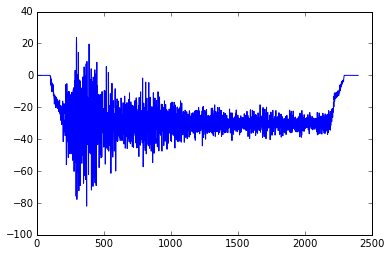

In [123]:
plot(result)
print np.max(result)
print np.argmax(result)


In [130]:
print np.linalg.norm(c)
print np.linalg.norm(c0)

print np.linalg.norm(c0) / np.linalg.norm(c)
print (np.dot(c0, c) ) / ( np.linalg.norm(c)**2)

2.57491440181
33.3375583382
12.9470549836
3.31726628129


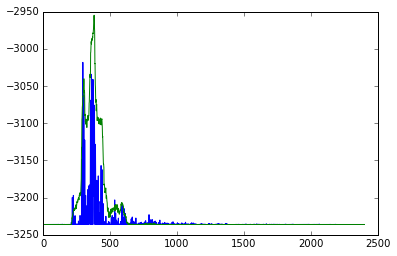

In [43]:
from sigvisa.infer.correlations.proposal_signal_likelihood import likelihood_windowed, iidbaseline
sdata = w1.data
sigma2_B = np.std(sdata)**2

iidb, _ = iidbaseline(sdata, 100, sigma2_B)

taus = np.linspace(0, 1, 50)
mls1= []
mls2 = []
#for tau in taus:
tau = 0.90
if True:
    wls1 = likelihood_windowed(sdata, tau*c1.data, 1-tau**2*k1, sigma2_B)
    lls1 = wls1 + iidb
    wls2 = likelihood_windowed(sdata, tau*c2.data, 1-tau**2*k2, sigma2_B)
    lls2 = wls2 + iidb
    plot(lls1)
    plot(lls2)
    #mls1.append(np.max(lls1))
    #mls2.append(np.max(lls2))
#plot(taus, mls1)
#plot(taus, mls2)


0.772066505807 296


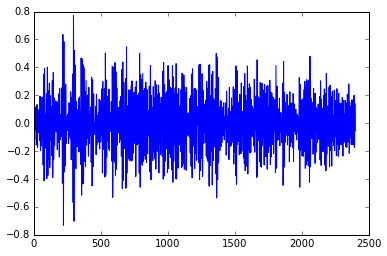

In [31]:
from sigvisa.signals.xc import my_xc
xxc = my_xc(c1.data, sdata)
plot(xxc)
print np.max(xxc), np.argmax(xxc)

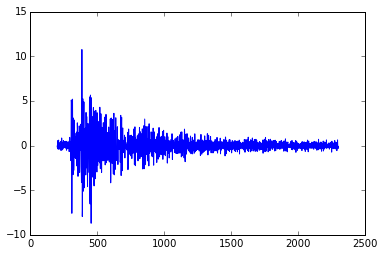

In [44]:
plot(sdata)

array([[  4.21852299,  -3.27852664,   6.07129456, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.27852664,   6.76650884,  -7.99697928, ...,   0.        ,
          0.        ,   0.        ],
       [  6.07129456,  -7.99697928,  15.50431062, ...,   0.        ,
          0.        ,   0.        ],
       ..., 
       [  0.        ,   0.        ,   0.        , ...,  15.50431062,
        -33.45613746,  39.51860056],
       [  0.        ,   0.        ,   0.        , ..., -33.45613746,
          6.76650884, -33.45613746],
       [  0.        ,   0.        ,   0.        , ...,  39.51860056,
        -33.45613746,   4.21852299]])

In [10]:
ct = w1.data[296:396]
c1 /= np.linalg.norm(c1)
nm.c = 0

diff = c1-ct
ardiff = nm.log_p(diff)
ara = nm.log_p(ct)
arb = nm.log_p(c1)
arnorm = nm.log_p(np.zeros(ct.shape))

cross = (arb + ara - ardiff-arnorm)/2.0
beta = cross / (arb - arnorm)
print beta

8.00465055845


In [11]:
iidiff = -.5*np.linalg.norm(diff)**2
iia = -.5*np.linalg.norm(ct)**2
iib = -.5*np.linalg.norm(c1)**2
iicross = (iib + iia - iidiff )/2.0
iibeta = iicross / iib
print iibeta

21.9523668486


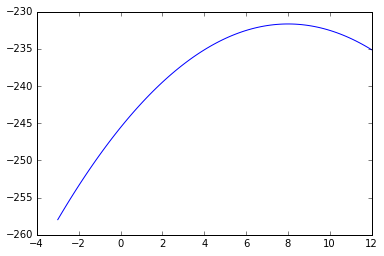

In [12]:
betas = np.linspace(-3, 12, 100)
lps = [nm.log_p(ct-beta*c1) for beta in betas]
plot(betas, lps)

In [48]:
print arnorm

n2 = 100*.5 * np.log(2*pi*nm.em.std**2)
print n2
# turns out all the extra variance is from first ten timesteps. which is fine! it a) won't affect me, and b) I can always just compute arnorm explicitly

-77.8774767549
19.9196001244


In [11]:
from sigvisa.models.noise.armodel.model import fastar_support
import scipy.weave as weave
from scipy.weave import converters

local_support = """

double reset_compute_ar(int n_p, blitz::Array<bool, 1> mask, blitz::Array<double, 1> d,
                      double var, blitz::Array<double, 1> p, blitz::Array<double, 2> tmp,
                       int start_idx,
                       int end_idx,
                       blitz::Array<double, 2> K,
                       blitz::Array<double, 1> u,
                       blitz::Array<double, 1> llarray,
                       int return_llarray) {
   for (int kk=0; kk < n_p; ++kk) {
        for (int kj=0; kj < n_p; ++kj) {
        K(kk, kj) = 0;
        tmp(kk, kj) = 0;
        }
        K(kk, kk) = 1e4;
        u(kk) = 0;
    }
    return compute_ar(n_p, mask, d, var, p, tmp, start_idx, end_idx, K, u, llarray, 0);
}
"""

arcode = """

    

for (int k=0; k < N-n-n_p; ++k) {
//for (int k=100; k < 500; ++k) {
    double f_a;
    double f_0;
    double g_b_a;
    double g_b;

    // TODO: can compute these outside of the loop if the mask is not changing. 
    for (int i=k-n_p; i < k+n+n_p; ++i) {
       if (i < 0) continue;
       tmpS(i) = 0.0;
    }    
    f_0 = reset_compute_ar(n_p, mask, tmpS, var, p, tmp, k, k+n+n_p, K, u, llarray, 0);
    
    for (int i=k; i < k+n; ++i) {
        tmpS(i) = c(i-k);
    }
    f_a = reset_compute_ar(n_p, mask, tmpS, var, p, tmp, k, k+n+n_p, K, u, llarray, 0);
    
    
    for (int i=k-n_p; i < k; ++i) {
       if (i < 0) continue;
       tmpS(i) = S(i);
    }    
    for (int i=k; i < k+n+n_p; ++i) {
        tmpS(i) = S(i);
    }
    g_b = reset_compute_ar(n_p, mask, tmpS, var, p, tmp, k, k+n+n_p, K, u, llarray, 0);
    
    for (int i=k; i < k+n; ++i) {
        tmpS(i) = S(i) - c(i-k);
    }
    g_b_a = reset_compute_ar(n_p, mask, tmpS, var, p, tmp, k, k+n+n_p, K, u, llarray, 0);
    
    double mnum = (g_b + f_a - g_b_a - f_0); // -(a' R^-1 (b-c))
    double mdenom = (2*(f_a - f_0)); // - a' R^-1 a;
    
    double beta_hat =  mnum / mdenom;

    double lp_delta = .5 * mdenom * beta_hat * beta_hat - mnum * beta_hat;

    result(k) = lp_delta;
}

"""

S = (w1.data.data - np.mean(w1.data)).copy()

tmpS = S.copy()
mask = w1.data.mask
c = np.array(c1/np.linalg.norm(c1))
N = len(S)
n = len(c)

nm = nmn
p = np.array(nm.params).copy()
n_p = len(p)
tmp = np.zeros((n_p, n_p))
K = np.eye(n_p) * 1.0e4
u = np.zeros((n_p,))
var = float(nm.em.std**2)
llarray = np.zeros((1,), dtype=np.float)
result = np.zeros((N-n),)
weave.inline(arcode,['S', 'mask', 'c', 'N', 'n', 'result', 'n_p', 'var', 'p', 'tmpS', 'tmp', 'K', 'u', 'llarray'],type_converters = converters.blitz,
                 verbose=2,compiler='gcc',support_code=fastar_support + local_support)



5039.40706172
296


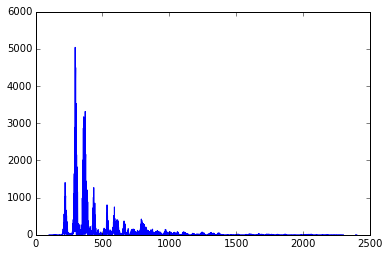

In [13]:
plot(result)
print np.max(result[200:2000])
print np.argmax(result[200:2000]) + 200

In [84]:
len(S)

4678

In [30]:
np.max(result)

nan

In [25]:
l1 =  nm.log_p(sdata)
ssdata = sdata.copy()
ssdata[296:396] -= 8.97 * c
l2 = nm.log_p(ssdata)
print l1, l2, l2-l1

-1350.31666391 -1326.15544443 24.1612194776
